In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
# Imports
import random
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
data.shape

(1600000, 6)

In [5]:
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Pre processing : 

In [6]:
# Removing the unnecessary columns.
data = data[['sentiment','text']]

# Replacing the values to ease understanding.
data['sentiment'] = data['sentiment'].replace(4,1)

In [7]:
data.sentiment.unique()

array([0, 1])

In [8]:
data.groupby('sentiment').count()

,text
sentiment,
0,800000
1,800000


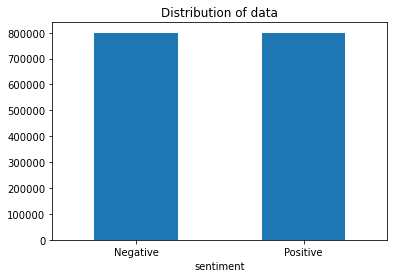

In [9]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0);

In [10]:
from nltk.stem import PorterStemmer

In [12]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [13]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
data.text = data.text.apply(lambda x: preprocess(x, False))

CPU times: user 1min 18s, sys: 195 ms, total: 1min 18s
Wall time: 1min 18s


In [16]:
# examining data
random_idx_list = [random.randint(1,len(data.text)) for i in range(10)] # creates random indexes to choose from dataframe
data.loc[random_idx_list,:].head(10) 

,sentiment,text
1243062,1,knew reason never play fire manage stick finge...
262666,0,hopes rock n roll trivia team super mario spee...
641703,0,must wake time one lie ins
266966,0,monday even started yet dead agree work full week
1415288,1,finished miles go mileycyrus less day know rea...
749605,0,apparently first attempt yes believed arson
1539272,1,pump interactive love
725670,0,thank sir sad come store week see young man
1482288,1,sorry hear working far give
1339418,1,tell help better understand law physics aerody...


### Vectorization

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
print("TRAIN size:", len(train))
print("TEST size:", len(train))

TRAIN size: 1280000
TEST size: 1280000


In [18]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

In [19]:
x_train = tfidfvectorizer.fit_transform(train['text'])
y_train = train['sentiment']
x_test = tfidfvectorizer.transform(test['text'])
y_test = test['sentiment']

### Learning Curve

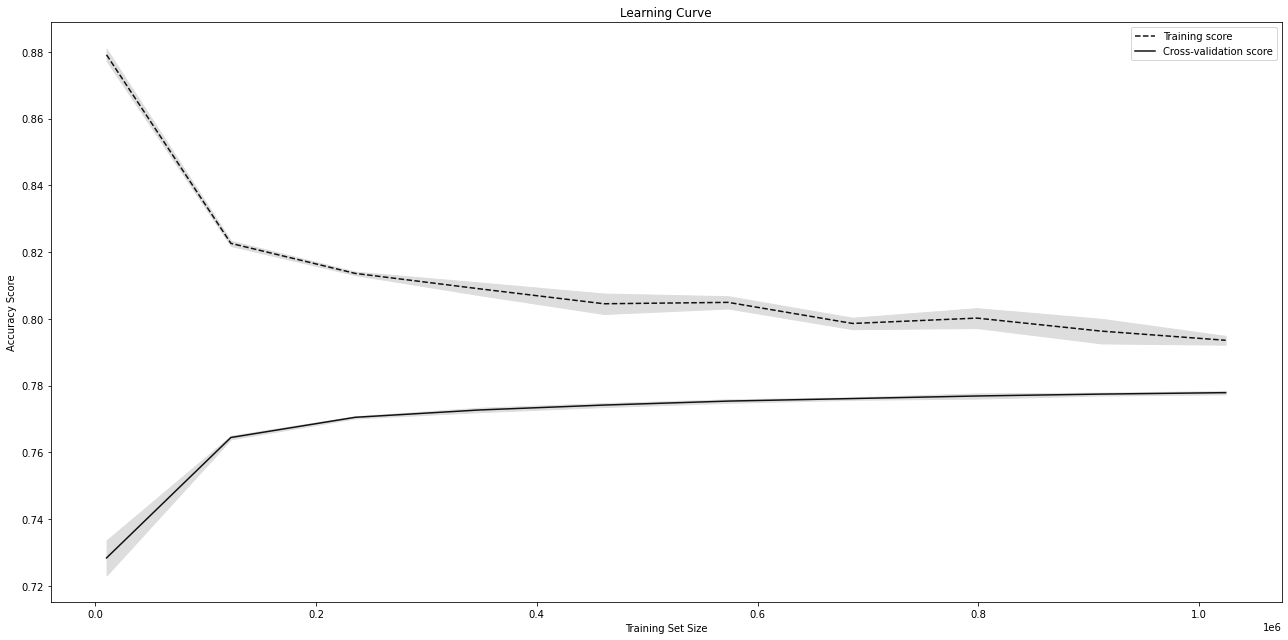

CPU times: user 1.06 s, sys: 787 ms, total: 1.85 s
Wall time: 4min 37s


In [20]:
%%time
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        x_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='f1',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.figure(figsize=(18, 9))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Hyper parameter tuning

In [21]:
param_grid = {"C":np.logspace(-3,3,3), "penalty":["l1","l2"]}
param_grid

{'C': array([1.e-03, 1.e+00, 1.e+03]), 'penalty': ['l1', 'l2']}

In [22]:
%%time
estimator = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
estimator.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


CPU times: user 51.6 s, sys: 1.1 s, total: 52.7 s
Wall time: 2min 12s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e+00, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=2)

In [24]:
def evaluate_model(estimator, x_train, y_train, x_test, y_test):

    print("Evaluating {} model ...".format(type(estimator).__name__))
    
    y1 = estimator.predict(x_train)
    print("-----------------------")
    train_acc = accuracy_score(y_train, y1)
    print("Training Accuracy : {}".format(train_acc))
    print(classification_report(y_train, y1))
    print(roc_auc_score(y_train, y1))

    
    y2 = estimator.predict(x_test)
    valid_acc = accuracy_score(y_test, y2)
    print("Validation Accuracy : {}".format(valid_acc))
    print(classification_report(y_test, y2))
    print(roc_auc_score(y_test, y2))
    print("\n")
    print(" =============== Complete ==============")

In [25]:
evaluate_model(estimator, x_train, y_train, x_test, y_test)

Evaluating GridSearchCV model ...
-----------------------
Training Accuracy : 0.786815625
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    640506
           1       0.77      0.81      0.79    639494

    accuracy                           0.79   1280000
   macro avg       0.79      0.79      0.79   1280000
weighted avg       0.79      0.79      0.79   1280000

0.7868362580136917
Validation Accuracy : 0.773084375
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

0.7730037438979132


 =============== Complete ==============
